In [4]:
!pip install nvcc4jupyter
!pip install cupy-cuda12x
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [2]:
%%writefile raytracing.cu
#include <iostream>
#include <cuda_runtime.h>
#include <cfloat>
#include <cmath>

#define checkCudaErrors(val) check_cuda( (val), #val, __FILE__, __LINE__ )
void check_cuda(cudaError_t result, char const *const func, const char *const file, int const line) {
    if (result != cudaSuccess) {
        std::cerr << "CUDA error = " << static_cast<unsigned int>(result) << " at " <<
            file << ":" << line << " '" << func << "' \n";
        std::cerr << "Error message: " << cudaGetErrorString(result) << std::endl;
        cudaDeviceReset();
        exit(99);
    }
}

class vec3 {
public:
    __host__ __device__ vec3() : e{0,0,0} {}
    __host__ __device__ vec3(float e0, float e1, float e2) : e{e0, e1, e2} {}

    __host__ __device__ float x() const { return e[0]; }
    __host__ __device__ float y() const { return e[1]; }
    __host__ __device__ float z() const { return e[2]; }

    __host__ __device__ vec3 operator+(const vec3 &v) const {
        return vec3(e[0]+v.e[0], e[1]+v.e[1], e[2]+v.e[2]);
    }
    __host__ __device__ vec3 operator-(const vec3 &v) const {
        return vec3(e[0]-v.e[0], e[1]-v.e[1], e[2]-v.e[2]);
    }
    __host__ __device__ vec3 operator*(float t) const {
        return vec3(t*e[0], t*e[1], t*e[2]);
    }
    __host__ __device__ vec3 operator/(float t) const {
        return *this * (1.0f/t);
    }

    __host__ __device__ float length() const {
        return sqrtf(e[0]*e[0] + e[1]*e[1] + e[2]*e[2]);
    }

    __host__ __device__ vec3 unit_vector() const {
        return *this / length();
    }

    float e[3];
};

__host__ __device__ inline vec3 operator*(float t, const vec3 &v) {
    return v * t;
}

__host__ __device__ inline float dot(const vec3 &u, const vec3 &v) {
    return u.e[0]*v.e[0] + u.e[1]*v.e[1] + u.e[2]*v.e[2];
}

// Луч (ray)
class ray {
public:
    __host__ __device__ ray() {}
    __host__ __device__ ray(const vec3& origin, const vec3& direction)
        : orig(origin), dir(direction) {}

    __host__ __device__ vec3 origin() const { return orig; }
    __host__ __device__ vec3 direction() const { return dir; }
    __host__ __device__ vec3 at(float t) const {
        return orig + t*dir;
    }

    vec3 orig;
    vec3 dir;
};

// Функция пересечения луча с сферой
__device__ bool hit_sphere(const vec3& center, float radius, const ray& r, float t_min, float t_max, float& t_hit) {
    vec3 oc = r.origin() - center;
    float a = dot(r.direction(), r.direction());
    float b = dot(oc, r.direction());
    float c = dot(oc, oc) - radius*radius;
    float discriminant = b*b - a*c;
    if (discriminant > 0) {
        float sqrt_disc = sqrtf(discriminant);
        float temp = (-b - sqrt_disc) / a;
        if (temp < t_max && temp > t_min) {
            t_hit = temp;
            return true;
        }
        temp = (-b + sqrt_disc) / a;
        if (temp < t_max && temp > t_min) {
            t_hit = temp;
            return true;
        }
    }
    return false;
}

// Функция цвета с трассировкой жёлтой сферы
__device__ vec3 ray_color(const ray& r) {
    vec3 sphere_center(0.0f, 0.0f, -1.0f);
    float sphere_radius = 0.5f;
    float t_hit;

    if (hit_sphere(sphere_center, sphere_radius, r, 0.001f, FLT_MAX, t_hit)) {
        vec3 hit_point = r.at(t_hit);
        vec3 normal = (hit_point - sphere_center).unit_vector();
        // Простой ламберт: цвет зависит от нормали, жёлтый базовый цвет
        vec3 base_color(1.0f, 1.0f, 0.0f);
        float intensity = 0.5f * (normal.y() + 1.0f); // от 0 до 1 по y нормали
        return intensity * base_color;
    }

    // Градиент неба
    vec3 unit_direction = r.direction().unit_vector();
    float t = 0.5f*(unit_direction.y() + 1.0f);
    return (1.0f - t)*vec3(1.0f, 1.0f, 1.0f) + t*vec3(0.5f, 0.7f, 1.0f);
}

// Ядро CUDA для рендеринга
__global__ void render(vec3 *fb, int max_x, int max_y, vec3 lower_left_corner, vec3 horizontal, vec3 vertical, vec3 origin) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    int j = threadIdx.y + blockIdx.y * blockDim.y;
    if (i >= max_x || j >= max_y) return;
    int pixel_index = j*max_x + i;

    float u = float(i) / float(max_x);
    float v = float(j) / float(max_y);
    ray r(origin, lower_left_corner + u*horizontal + v*vertical - origin);
    fb[pixel_index] = ray_color(r);
}

int main() {
    const int nx = 1200;
    const int ny = 600;
    const int num_pixels = nx*ny;
    size_t fb_size = num_pixels * sizeof(vec3);

    vec3 *fb;
    checkCudaErrors(cudaMallocManaged((void**)&fb, fb_size));

    vec3 lower_left_corner(-2.0f, -1.0f, -1.0f);
    vec3 horizontal(4.0f, 0.0f, 0.0f);
    vec3 vertical(0.0f, 2.0f, 0.0f);
    vec3 origin(0.0f, 0.0f, 0.0f);

    int tx = 8;
    int ty = 8;
    dim3 blocks((nx + tx - 1)/tx, (ny + ty - 1)/ty);
    dim3 threads(tx, ty);

    render<<<blocks, threads>>>(fb, nx, ny, lower_left_corner, horizontal, vertical, origin);
    checkCudaErrors(cudaGetLastError());
    checkCudaErrors(cudaDeviceSynchronize());

    std::cout << "P3\n" << nx << " " << ny << "\n255\n";
    for (int j = ny-1; j >= 0; j--) {
        for (int i = 0; i < nx; i++) {
            int pixel_index = j*nx + i;
            int ir = static_cast<int>(255.99f * fb[pixel_index].x());
            int ig = static_cast<int>(255.99f * fb[pixel_index].y());
            int ib = static_cast<int>(255.99f * fb[pixel_index].z());
            std::cout << ir << " " << ig << " " << ib << "\n";
        }
    }

    checkCudaErrors(cudaFree(fb));
    return 0;
}


Writing raytracing.cu



real	0m0.290s
user	0m0.196s
sys	0m0.091s


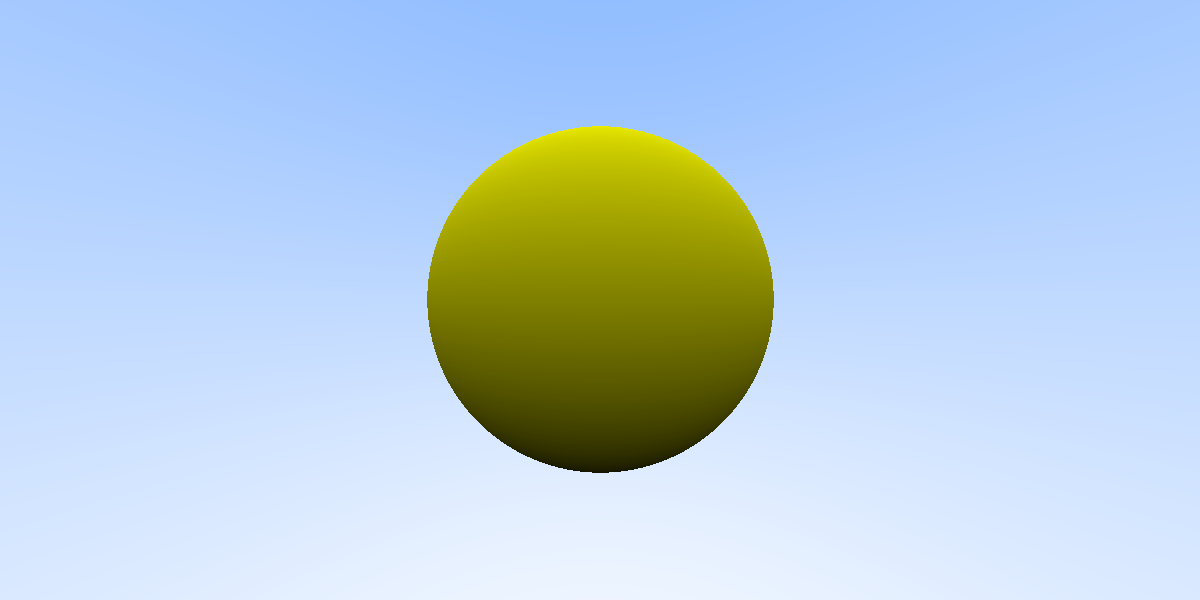

In [16]:
!nvcc -arch=sm_75 -o raytracing raytracing.cu  # sm_37 для K80, sm_80 для A100[4][5]

from PIL import Image
import numpy as np

times = {}

cpp_exec_time = !time ./raytracing > output.ppm
times['cpp_kernel'] = float(cpp_exec_time[1].split('m')[1][:-1]) * 1000

with open('output.ppm') as f:
    data = np.loadtxt(f, skiprows=3, dtype=np.uint8).reshape(600,1200,3)

Image.fromarray(data, 'RGB')


In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cupy as cp

In [19]:
# Common scene parameters
nx, ny = 1200, 600
aspect_ratio = nx / ny
fov = np.pi / 3.0
lower_left = np.array([-2.0, -1.0, -1.0])
horizontal = np.array([4.0, 0.0, 0.0])
vertical = np.array([0.0, 2.0, 0.0])
origin = np.array([0.0, 0.0, 0.0])
sphere_center = np.array([0.0, 0.0, -1.0])
sphere_radius = 0.5

def ray_color(ro, rd):
    # ray-sphere intersection
    oc = ro - sphere_center
    a = np.dot(rd, rd)
    b = np.dot(oc, rd)
    c = np.dot(oc, oc) - sphere_radius**2
    disc = b*b - a*c
    if disc > 0:
        t = (-b - np.sqrt(disc)) / a
        if t > 0.001:
            hit = ro + t*rd
            normal = (hit - sphere_center) / np.linalg.norm(hit - sphere_center)
            base = np.array([1.0, 1.0, 0.0])
            intensity = 0.5 * (normal[1] + 1.0)
            return intensity * base
    # sky
    udir = rd / np.linalg.norm(rd)
    t = 0.5 * (udir[1] + 1.0)
    return (1-t)*np.array([1.0,1.0,1.0]) + t*np.array([0.5,0.7,1.0])


In [20]:
def render_sequential():
    image = np.zeros((ny, nx, 3), dtype=np.float32)
    for j in range(ny):
        for i in range(nx):
            u = i / nx
            v = j / ny
            dir = lower_left + u*horizontal + v*vertical - origin
            dir = dir / np.linalg.norm(dir)
            image[ny-1-j, i] = ray_color(origin, dir)
    return image

In [11]:
def render_cupy_vectorized():
    # define in form of cupy arrays
    lower_left = cp.array([-2.0, -1.0, -1.0])
    horizontal = cp.array([4.0, 0.0, 0.0])
    vertical = cp.array([0.0, 2.0, 0.0])
    origin = cp.array([0.0, 0.0, 0.0])
    sphere_center = cp.array([0.0, 0.0, -1.0])

    i = cp.arange(nx).reshape(1, nx)
    j = cp.arange(ny).reshape(ny, 1)
    u = i / nx
    v = j / ny

    dirs = lower_left[None,None,:] + u[:,:,None]*horizontal + v[:,:,None]*vertical - origin
    norms = cp.linalg.norm(dirs, axis=2, keepdims=True)
    dirs = dirs / norms

    # call ray_color on arrays
    oc = origin - sphere_center
    b = cp.sum(dirs * oc[None,None,:], axis=2)
    c = cp.sum(oc*oc) - sphere_radius**2
    disc = b*b - c * cp.sum(dirs*dirs, axis=2)
    mask = disc > 0

    t = (-b - cp.sqrt(disc)) / cp.sum(dirs*dirs, axis=2)
    hit = origin + dirs * t[:,:,None]
    normal = (hit - sphere_center) / cp.linalg.norm(hit - sphere_center, axis=2, keepdims=True)
    base = cp.array([1.0,1.0,0.0])
    intensity = 0.5 * (normal[:,:,1] + 1.0)
    col_sphere = (intensity[:,:,None] * base[None,None,:])
    udir = dirs / norms
    t_sky = 0.5 * (udir[:,:,1] + 1.0)
    col_sky = (1-t_sky)[:,:,None]*cp.array([1.0,1.0,1.0])[None,None,:] + t_sky[:,:,None]*cp.array([0.5,0.7,1.0])[None,None,:]
    image = cp.where(mask[:,:,None], col_sphere, col_sky)

    return cp.asnumpy(image)

In [12]:
kernel_code = r'''
extern "C" __global__
void render_kernel(float *fb, int nx, int ny) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i>=nx || j>=ny) return;
    int idx = j*nx + i;
    float u = float(i)/nx;
    float v = float(j)/ny;
    float orig[3] = {0,0,0};
    float ll[3] = {-2,-1,-1};
    float h[3] = {4,0,0};
    float vvec[3] = {0,2,0};
    float sc[3] = {0,0,-1};
    float rad = 0.5f;
    float dir[3] = { ll[0]+u*h[0]+v*vvec[0]-orig[0],
                     ll[1]+u*h[1]+v*vvec[1]-orig[1],
                     ll[2]+u*h[2]+v*vvec[2]-orig[2] };
    float norm = sqrtf(dir[0]*dir[0]+dir[1]*dir[1]+dir[2]*dir[2]);
    dir[0]/=norm; dir[1]/=norm; dir[2]/=norm;
    // intersect
    float oc[3] = {orig[0]-sc[0], orig[1]-sc[1], orig[2]-sc[2]};
    float a = dir[0]*dir[0]+dir[1]*dir[1]+dir[2]*dir[2];
    float b = oc[0]*dir[0]+oc[1]*dir[1]+oc[2]*dir[2];
    float c = oc[0]*oc[0]+oc[1]*oc[1]+oc[2]*oc[2] - rad*rad;
    float disc = b*b - a*c;
    float col[3];
    if (disc>0) {
        float t = (-b - sqrtf(disc))/a;
        if (t>0.001f) {
            float hit[3] = {orig[0]+t*dir[0], orig[1]+t*dir[1], orig[2]+t*dir[2]};
            float nx_ = (hit[0]-sc[0])/rad;
            float ny_ = (hit[1]-sc[1])/rad;
            float nz_ = (hit[2]-sc[2])/rad;
            float intensity = 0.5f*(ny_+1.0f);
            col[0]=intensity; col[1]=intensity; col[2]=0;
        } else disc = -1;
    }
    if (disc<=0) {
        // sky
        float tsky = 0.5f*(dir[1]+1.0f);
        col[0]=(1-tsky)+tsky*0.5f;
        col[1]=(1-tsky)+tsky*0.7f;
        col[2]=(1-tsky)+tsky*1.0f;
    }
    fb[3*idx+0] = col[0];
    fb[3*idx+1] = col[1];
    fb[3*idx+2] = col[2];
}
'''
render_kernel = cp.RawKernel(kernel_code, 'render_kernel')

def render_cupy_kernel():
    fb = cp.zeros(3*nx*ny, dtype=cp.float32)
    threads = (16, 16)
    blocks = ((nx+15)//16, (ny+15)//16)
    # prepare params
    params = (fb, nx, ny,
              *lower_left, *horizontal, *vertical,
              *origin, *sphere_center, sphere_radius)
    start = cp.cuda.Event()
    stop = cp.cuda.Event()
    start.record()
    render_kernel(blocks, threads, params)
    stop.record()
    stop.synchronize()
    elapsed = cp.cuda.get_elapsed_time(start, stop)
    img = fb.reshape(ny, nx, 3).get()
    return img, elapsed

sequential: 13921.14 ms
cupy_vectorized: 128.12 ms
cupy_kernel: 0.14 ms
cpp_kernel: 286.00 ms


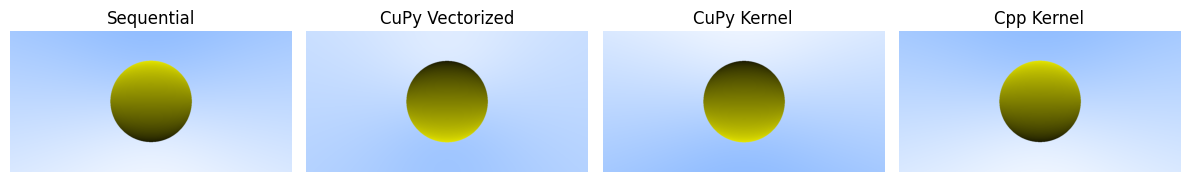

In [30]:

start = time.perf_counter()
seq_img = render_sequential()
times['sequential'] = (time.perf_counter() - start) * 1000  # ms

cp.cuda.Stream.null.synchronize()
start = time.perf_counter()
cupy_vec_img = render_cupy_vectorized()
cp.cuda.Stream.null.synchronize()
times['cupy_vectorized'] = (time.perf_counter() - start) * 1000  # ms

cupy_ker_img, ker_time = render_cupy_kernel()
times['cupy_kernel'] = ker_time  # direct GPU timing

#show elapsed time
for k, v in times.items():
    print(f"{k}: {v:.2f} ms")

#show result images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for ax, img, title in zip(axes, [seq_img, cupy_vec_img, cupy_ker_img, data],
                          ['Sequential', 'CuPy Vectorized', 'CuPy Kernel', "Cpp Kernel"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

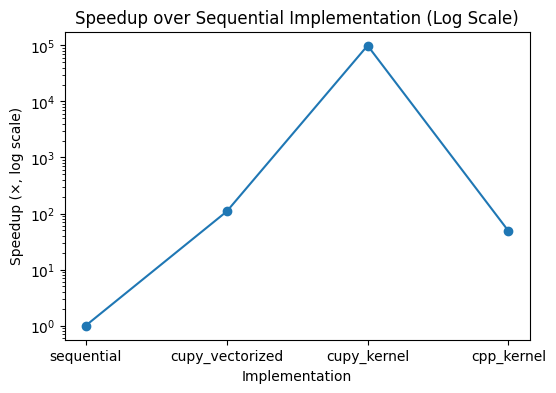

In [36]:
methods = list(times.keys())
speedups = [times['sequential'] / times[m] for m in methods]

plt.figure(figsize=(6, 4))
plt.plot(methods, speedups, marker='o')
plt.yscale('log')  # Use logarithmic scale on the y-axis
plt.ylabel('Speedup (×, log scale)')
plt.xlabel('Implementation')
plt.title('Speedup over Sequential Implementation (Log Scale)')
plt.show()